# Forschungsfrage

### Wie zuverlässig lassen sich Hassrede, Beleidigungen und neutrale Sprache in sozialen Medien mit klassischen ML-Algorithmen und  modernen Transformer-Modellen erkennen?

## Datenset
https://www.kaggle.com/datasets/mrmorj/hate-speech-and-offensive-language-dataset

## Herangehensweise
Als erstes wollen wir herkömmliche ML-Algortihmen evaluieren, um ein Gefühl für die durchschnittliche Performance mit diesem Datensetz zu bekommen. Anschließend verwenden wir dann ein pretrained-Transformer-Model "distilbert-base-uncased" und trainieren es anhand unserer Train-Daten.

## 1. Data Exploration

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import nltk
import torch
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from wordcloud import WordCloud
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from datasets import Dataset, ClassLabel
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, TextClassificationPipeline 

In [26]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\David\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\David\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [27]:
df = pd.read_csv("labeled_data.csv")
df.head(20)

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
5,5,3,1,2,0,1,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just..."
6,6,3,0,3,0,1,"!!!!!!""@__BrighterDays: I can not just sit up ..."
7,7,3,0,3,0,1,!!!!&#8220;@selfiequeenbri: cause I'm tired of...
8,8,3,0,3,0,1,""" &amp; you might not get ya bitch back &amp; ..."
9,9,3,1,2,0,1,""" @rhythmixx_ :hobbies include: fighting Maria..."


In [28]:
df.info()
df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000,24783
unique,NaN,NaN,NaN,NaN,NaN,NaN,24783
top,NaN,NaN,NaN,NaN,NaN,NaN,~~Ruffled | Ntac Eileen Dahlia - Beautiful col...
freq,NaN,NaN,NaN,NaN,NaN,NaN,1
mean,12681.192027,3.243473,0.280515,2.413711,0.549247,1.110277,NaN
std,7299.553863,0.883060,0.631851,1.399459,1.113299,0.462089,NaN
min,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,6372.500000,3.000000,0.000000,2.000000,0.000000,1.000000,NaN
50%,12703.000000,3.000000,0.000000,3.000000,0.000000,1.000000,NaN
75%,18995.500000,3.000000,0.000000,3.000000,0.000000,1.000000,NaN


In [29]:
df['class'].value_counts()

class
1    19190
2     4163
0     1430
Name: count, dtype: int64

## 2. Data Preperation

In [30]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)         # URLs entfernen
    text = re.sub(r"@\w+", "", text)            # Mentions entfernen
    text = re.sub(r"[^a-z\s]", "", text)        # Sonderzeichen entfernen
    return text

df['cleaned_text'] = df['tweet'].astype(str).apply(clean_text)
df[['tweet', 'cleaned_text']].head(10)


,tweet,cleaned_text
0,!!! RT @mayasolovely: As a woman you shouldn't...,rt as a woman you shouldnt complain about cl...
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,rt boy dats coldtyga dwn bad for cuffin dat ...
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,rt dawg rt you ever fuck a bitch and she st...
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,rt she look like a tranny
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,rt the shit you hear about me might be true ...
5,"!!!!!!!!!!!!!!!!!!""@T_Madison_x: The shit just...",the shit just blows meclaim you so faithful a...
6,"!!!!!!""@__BrighterDays: I can not just sit up ...",i can not just sit up and hate on another bit...
7,!!!!&#8220;@selfiequeenbri: cause I'm tired of...,cause im tired of you big bitches coming for ...
8,""" &amp; you might not get ya bitch back &amp; ...",amp you might not get ya bitch back amp thats...
9,""" @rhythmixx_ :hobbies include: fighting Maria...",hobbies include fighting mariam\n\nbitch


In [31]:
stop_words = set(stopwords.words('english'))

def tokenize_and_remove_stopwords(text):
    tokens = word_tokenize(text, preserve_line=True)
    filtered = [word for word in tokens if word not in stop_words]
    return " ".join(filtered)


df['processed_text'] = df['cleaned_text'].apply(tokenize_and_remove_stopwords)
df[['cleaned_text', 'processed_text']].head()


,cleaned_text,processed_text
0,rt as a woman you shouldnt complain about cl...,rt woman shouldnt complain cleaning house amp ...
1,rt boy dats coldtyga dwn bad for cuffin dat ...,rt boy dats coldtyga dwn bad cuffin dat hoe st...
2,rt dawg rt you ever fuck a bitch and she st...,rt dawg rt ever fuck bitch start cry confused ...
3,rt she look like a tranny,rt look like tranny
4,rt the shit you hear about me might be true ...,rt shit hear might true might faker bitch told ya


In [32]:
label_mapping = {
    0: 'Hate Speech',
    1: 'Offensive Language',
    2: 'Neither'
}

df['label'] = df['class'].map(label_mapping)

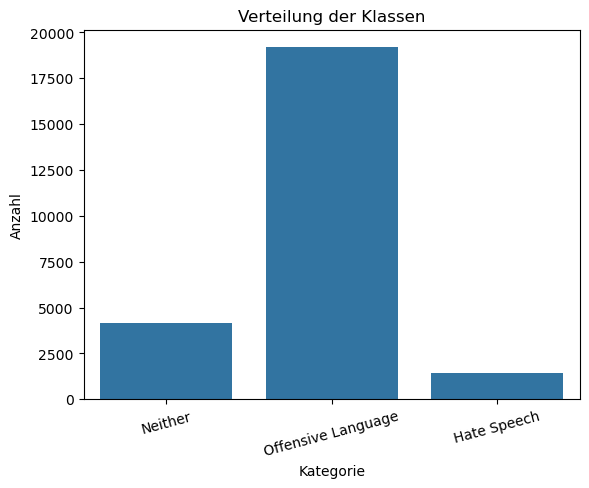

In [33]:
sns.countplot(data=df, x='label')
plt.title("Verteilung der Klassen")
plt.xlabel("Kategorie")
plt.ylabel("Anzahl")
plt.xticks(rotation=15)
plt.show()

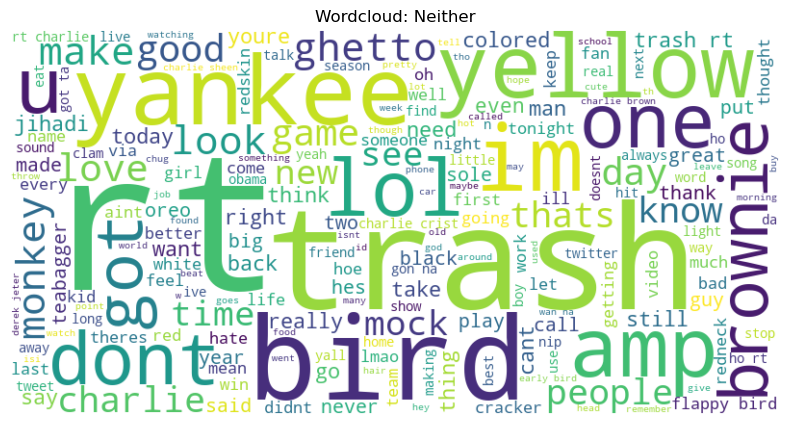

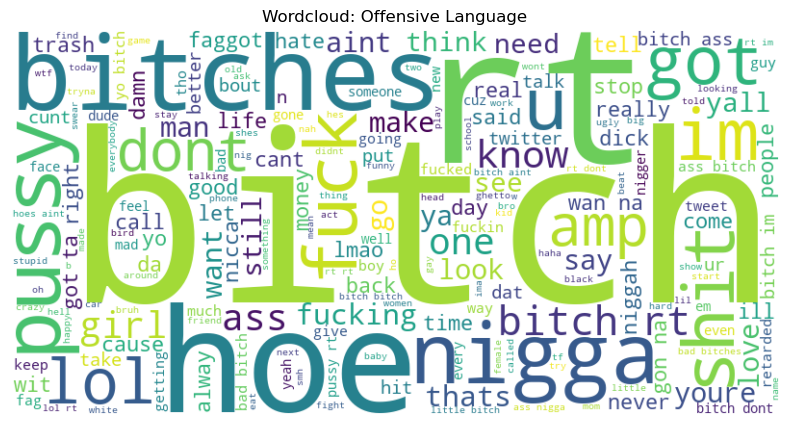

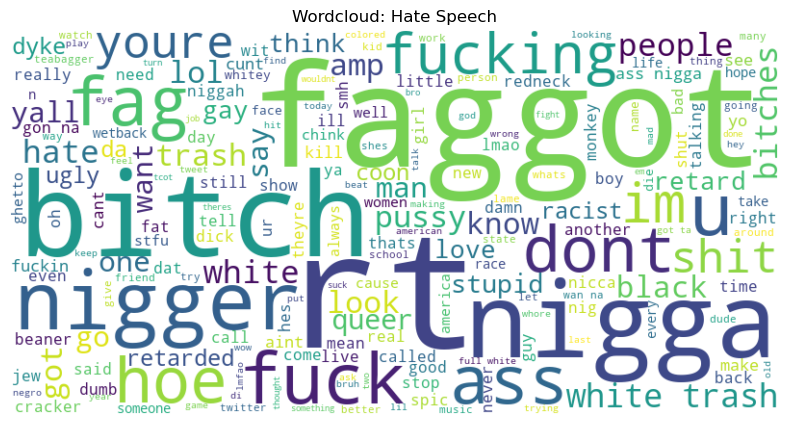

In [34]:
def show_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

for label in df['label'].unique():
    subset = df[df['label'] == label]
    show_wordcloud(subset['processed_text'], f"Wordcloud: {label}")


## 3. Statistische und herkömmliche ML-Algorithmen

In [11]:
X = df['processed_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [12]:
# TF-IDF + Klassifikation
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
])


# training
pipeline.fit(X_train, y_train)

# prediction
y_pred = pipeline.predict(X_test)

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))

Classification Report:

                    precision    recall  f1-score   support

       Hate Speech       0.32      0.62      0.42       286
           Neither       0.76      0.94      0.85       833
Offensive Language       0.97      0.85      0.91      3838

          accuracy                           0.86      4957
         macro avg       0.69      0.81      0.73      4957
      weighted avg       0.90      0.86      0.87      4957

Confusion Matrix:

[[ 178   29   79]
 [  24  787   22]
 [ 351  213 3274]]


In [38]:
models = [
    ("Logistic Regression", LogisticRegression(max_iter=1000, class_weight='balanced')),
    ("Naive Bayes", MultinomialNB()),
    ("Linear SVM", LinearSVC(class_weight='balanced'))
]

results = []

for name, model in models:
    print(f"\n Testing model: {name}")
    
    pipe = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
        ('clf', model)
    ])
    
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    results.append((name, acc, f1_macro))


 Testing model: Logistic Regression
Classification Report:
                    precision    recall  f1-score   support

       Hate Speech       0.32      0.62      0.42       286
           Neither       0.76      0.94      0.85       833
Offensive Language       0.97      0.85      0.91      3838

          accuracy                           0.86      4957
         macro avg       0.69      0.81      0.73      4957
      weighted avg       0.90      0.86      0.87      4957


 Testing model: Naive Bayes
Classification Report:
                    precision    recall  f1-score   support

       Hate Speech       1.00      0.01      0.02       286
           Neither       0.90      0.49      0.64       833
Offensive Language       0.85      0.99      0.91      3838

          accuracy                           0.85      4957
         macro avg       0.91      0.50      0.52      4957
      weighted avg       0.86      0.85      0.81      4957


 Testing model: Linear SVM
Classification


 Vergleich der Modelle:


,Model,Accuracy,F1_macro
0,Logistic Regression,0.855154,0.725816
1,Naive Bayes,0.850514,0.522804
2,Linear SVM,0.879363,0.716490


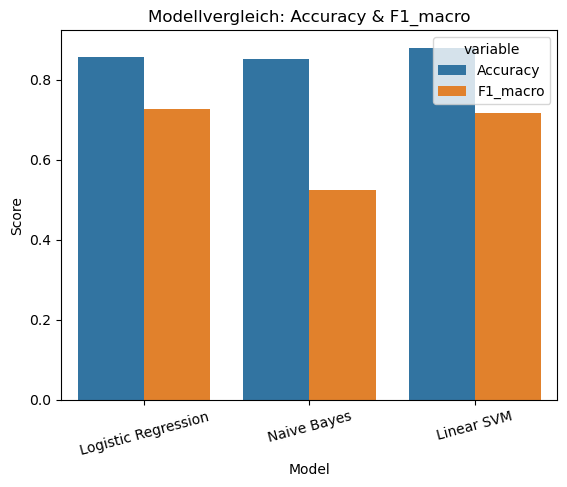

In [39]:
df_results = pd.DataFrame(results, columns=["Model", "Accuracy", "F1_macro"])
print("\n Vergleich der Modelle:")
display(df_results)

sns.barplot(data=df_results.melt(id_vars="Model"), x="Model", y="value", hue="variable")
plt.title("Modellvergleich: Accuracy & F1_macro")
plt.ylabel("Score")
plt.xticks(rotation=15)
plt.show()

Accuracy: 0.8846076255799878
Confusion Matrix:
 [[  31   18  227]
 [   3  629  175]
 [  32  117 3725]]
Classification Report:
                     precision    recall  f1-score   support

       Hate Speech       0.47      0.11      0.18       276
           Neither       0.82      0.78      0.80       807
Offensive Language       0.90      0.96      0.93      3874

          accuracy                           0.88      4957
         macro avg       0.73      0.62      0.64      4957
      weighted avg       0.87      0.88      0.87      4957



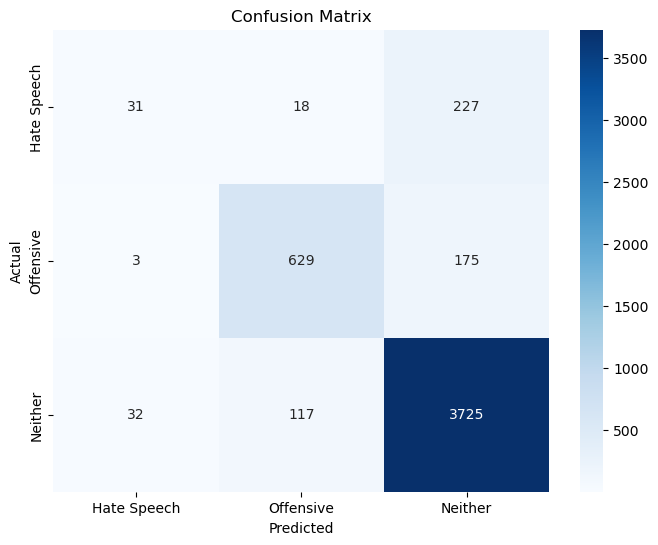

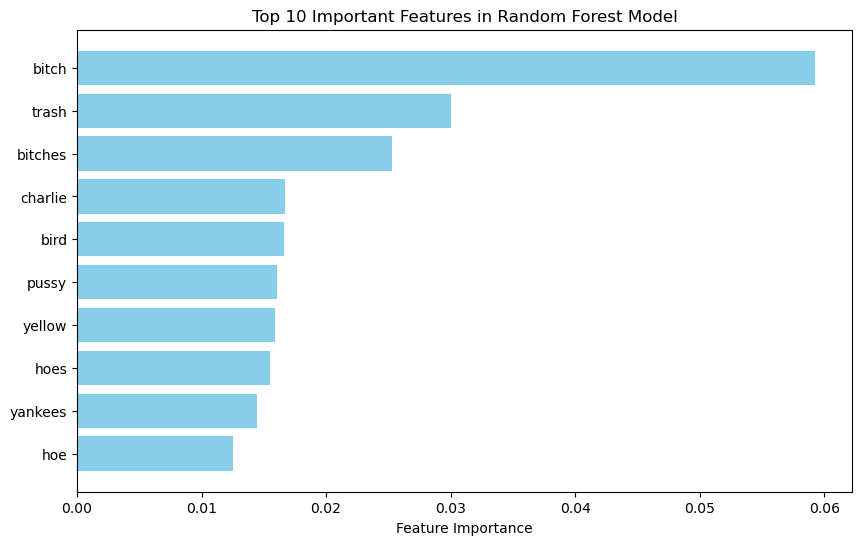

C:\Users\David\AppData\Local\Temp\ipykernel_15104\2241293560.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_pred, palette="Set2")


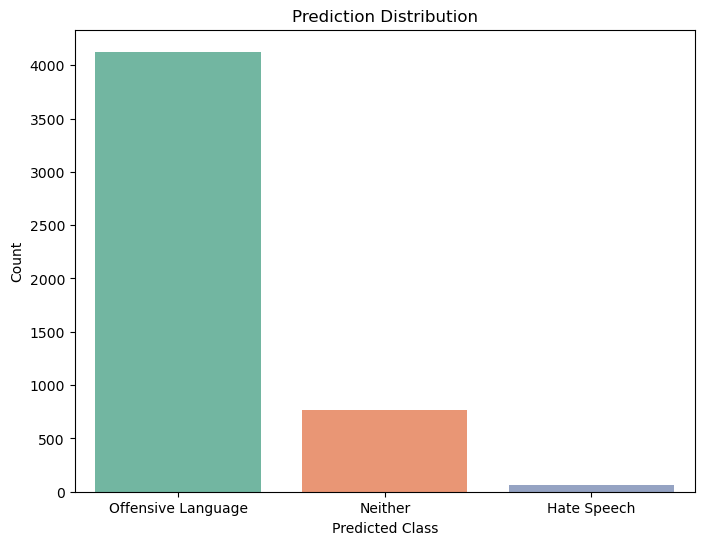

C:\Users\David\AppData\Local\Temp\ipykernel_15104\2241293560.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_test, palette="Set1")


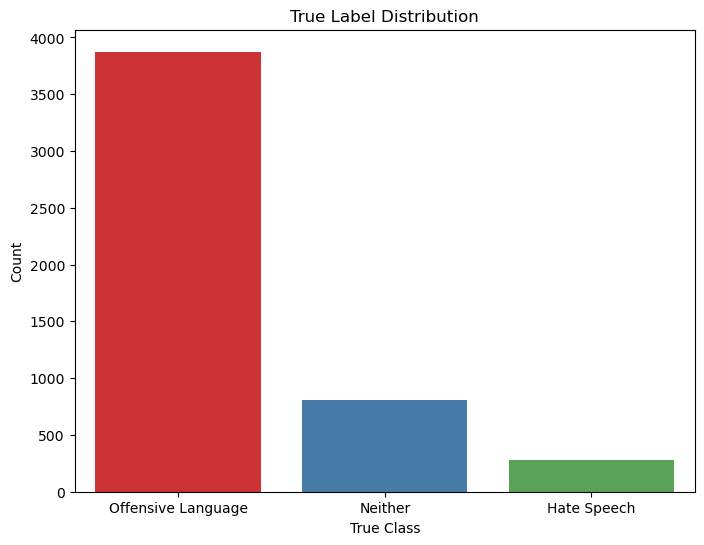

In [40]:
# Features & Target
X = df["cleaned_text"]
y = df["label"]  # Verwende die Originalklasse (0 = hate speech, 1 = offensive, 2 = neither)

# Text-Vektorisierung (TF-IDF)
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_vectorized = vectorizer.fit_transform(X)

# Trainings-/Test-Split
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=9)

# Modell trainieren (z.B. Random Forest)
model = RandomForestClassifier(random_state=9)
model.fit(X_train, y_train)

# Vorhersage & Auswertung
y_pred = model.predict(X_test)

# Ausgabe der grundlegenden Metriken
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Visualisierung: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Hate Speech", "Offensive", "Neither"], yticklabels=["Hate Speech", "Offensive", "Neither"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Visualisierung: Feature-Wichtigkeit
importances = model.feature_importances_
indices = importances.argsort()[-10:][::-1]  # Die 10 wichtigsten Features
top_features = [vectorizer.get_feature_names_out()[i] for i in indices]

plt.figure(figsize=(10, 6))
plt.barh(top_features, importances[indices], color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Top 10 Important Features in Random Forest Model")
plt.gca().invert_yaxis()  # Wichtigste Features oben
plt.show()

# Visualisierung der Vorhersagen
plt.figure(figsize=(8, 6))
sns.countplot(x=y_pred, palette="Set2")
plt.title("Prediction Distribution")
plt.xlabel("Predicted Class")
plt.ylabel("Count")
plt.show()

# Visualisierung der tatsächlichen Labels
plt.figure(figsize=(8, 6))
sns.countplot(x=y_test, palette="Set1")
plt.title("True Label Distribution")
plt.xlabel("True Class")
plt.ylabel("Count")
plt.show()

Accuracy: 0.8739156748033085
Confusion Matrix:
 [[  73   13  190]
 [   4  521  282]
 [  51   85 3738]]
Classification Report:
                     precision    recall  f1-score   support

       Hate Speech       0.57      0.26      0.36       276
           Neither       0.84      0.65      0.73       807
Offensive Language       0.89      0.96      0.92      3874

          accuracy                           0.87      4957
         macro avg       0.77      0.62      0.67      4957
      weighted avg       0.86      0.87      0.86      4957



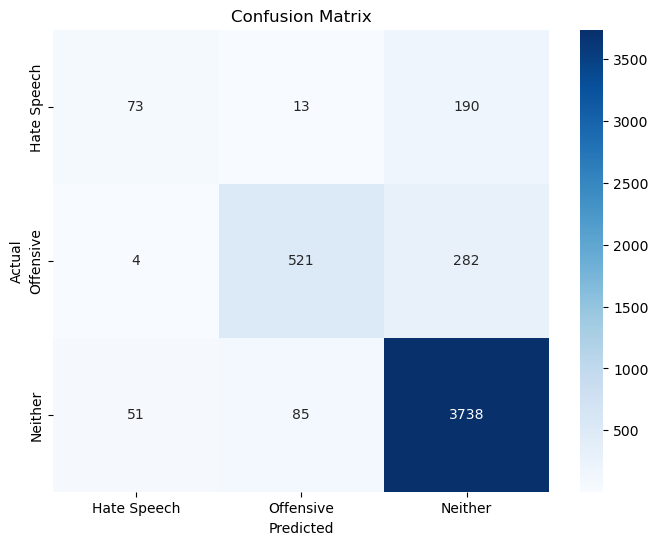

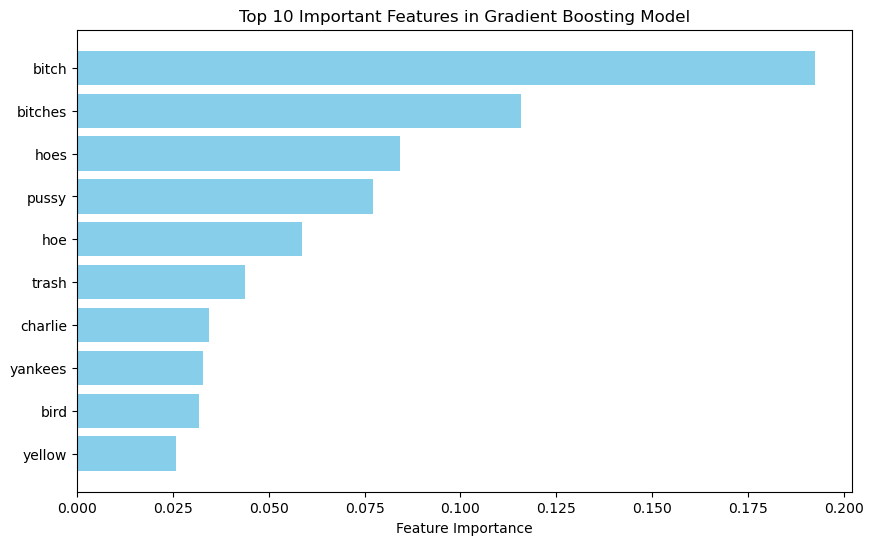

C:\Users\David\AppData\Local\Temp\ipykernel_15104\732554678.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_pred, palette="Set2")


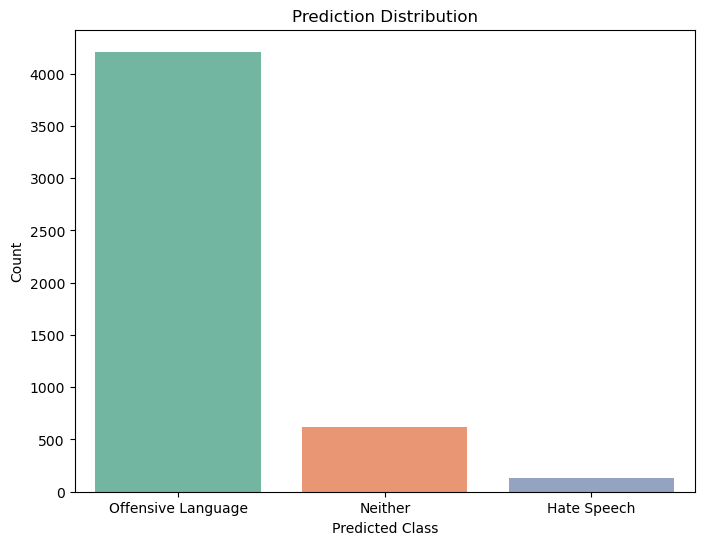

C:\Users\David\AppData\Local\Temp\ipykernel_15104\732554678.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_test, palette="Set1")


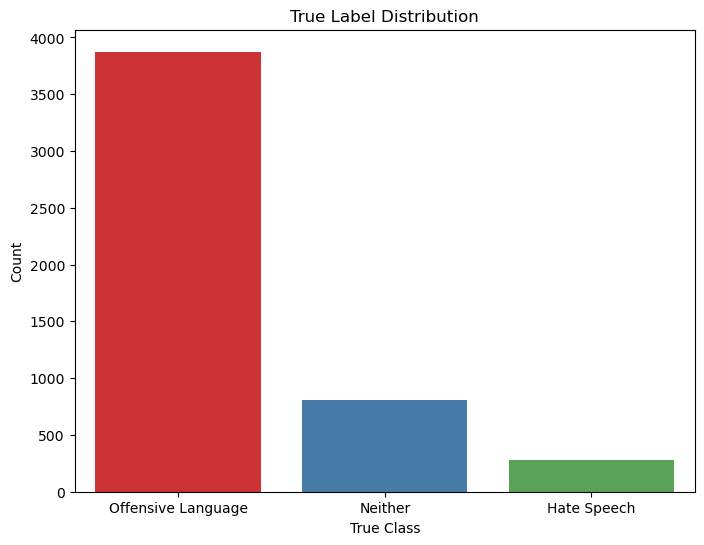

In [16]:
# Features & Target
X = df["cleaned_text"]
y = df["label"]  # Verwende die Originalklasse (0 = hate speech, 1 = offensive, 2 = neither)

# Text-Vektorisierung (TF-IDF)
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_vectorized = vectorizer.fit_transform(X)

# Trainings-/Test-Split
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=9)

# Modell trainieren (z.B. Gradient Boosting)
model = GradientBoostingClassifier(random_state=9)
model.fit(X_train, y_train)

# Vorhersage & Auswertung
y_pred = model.predict(X_test)

# Ausgabe der grundlegenden Metriken
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Visualisierung: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Hate Speech", "Offensive", "Neither"], yticklabels=["Hate Speech", "Offensive", "Neither"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Visualisierung: Feature-Wichtigkeit
importances = model.feature_importances_
indices = importances.argsort()[-10:][::-1]  # Die 10 wichtigsten Features
top_features = [vectorizer.get_feature_names_out()[i] for i in indices]

plt.figure(figsize=(10, 6))
plt.barh(top_features, importances[indices], color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Top 10 Important Features in Gradient Boosting Model")
plt.gca().invert_yaxis()  # Wichtigste Features oben
plt.show()

# Visualisierung der Vorhersagen
plt.figure(figsize=(8, 6))
sns.countplot(x=y_pred, palette="Set2")
plt.title("Prediction Distribution")
plt.xlabel("Predicted Class")
plt.ylabel("Count")
plt.show()

# Visualisierung der tatsächlichen Labels
plt.figure(figsize=(8, 6))
sns.countplot(x=y_test, palette="Set1")
plt.title("True Label Distribution")
plt.xlabel("True Class")
plt.ylabel("Count")
plt.show()


## 4. Transformer Modelle

In [35]:
# Wir vergleichen klassische ML-Methoden mit modernen vortrainierten Sprachmodellen und analysieren, 
# ob sich der erhöhte Aufwand in Praxisanwendungen wie Hate Speech Detection auszahlt.“

In [36]:
# Nur die nötigen Spalten auswählen
df_model = df[["processed_text", "label"]].dropna()
label2id = {"Hate Speech": 0, "Offensive Language": 1, "Neither": 2}
id2label = {v: k for k, v in label2id.items()}
df_model["label_id"] = df_model["label"].map(label2id)

# Konvertieren in Hugging Face Dataset
dataset = Dataset.from_pandas(df_model[["processed_text", "label_id"]])

# Label-Spalte als ClassLabel-Typ deklarieren
features = dataset.features.copy()
features["label_id"] = ClassLabel(num_classes=3, names=["Hate Speech", "Offensive Language", "Neither"])
dataset = dataset.cast(features)

# Jetzt klappt Stratified Split
dataset = dataset.train_test_split(test_size=0.2, stratify_by_column="label_id")


Casting the dataset:   0%|          | 0/24783 [00:00<?, ? examples/s]

In [37]:
model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def tokenize_function(example):
    return tokenizer(example["processed_text"], truncation=True, padding="max_length", max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/19826 [00:00<?, ? examples/s]

Map:   0%|          | 0/4957 [00:00<?, ? examples/s]

In [38]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=3,
    id2label=id2label,
    label2id=label2id
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
print('Cuda available: ', torch.cuda.is_available())
print('torch version: ', torch.__version__)
if torch.cuda.is_available():
    # Get the CUDA version
    cuda_version = torch.version.cuda
    print(f"CUDA version: ", cuda_version)

Cuda available:  True
torch version:  2.6.0+cu126
CUDA version:  12.6


In [40]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = predictions.argmax(axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
    }

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=5,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    logging_dir="./logs",
    logging_steps=50,
    load_best_model_at_end=True,
)

tokenized_datasets = tokenized_datasets.rename_column("label_id", "labels")
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)


In [41]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.256000,0.272349,0.900545,0.749787
2,0.231900,0.248184,0.911438,0.672287
3,0.177700,0.254294,0.909623,0.760206
4,0.136800,0.284298,0.907404,0.719750
5,0.115000,0.291105,0.908211,0.750173


TrainOutput(global_step=775, training_loss=0.19957372726932648, metrics={'train_runtime': 282.0535, 'train_samples_per_second': 351.458, 'train_steps_per_second': 2.748, 'total_flos': 3282931852577280.0, 'train_loss': 0.19957372726932648, 'epoch': 5.0})

In [42]:
metrics = trainer.evaluate()
print(metrics)

# Optional: detaillierter Report
predictions = trainer.predict(tokenized_datasets["test"])
y_true = predictions.label_ids
y_pred = predictions.predictions.argmax(axis=1)
print(classification_report(y_true, y_pred, target_names=label2id.keys()))


{'eval_loss': 0.24818408489227295, 'eval_accuracy': 0.9114383699818439, 'eval_f1_macro': 0.6722869436819515, 'eval_runtime': 4.911, 'eval_samples_per_second': 1009.369, 'eval_steps_per_second': 7.941, 'epoch': 5.0}
                    precision    recall  f1-score   support

       Hate Speech       0.56      0.11      0.18       286
Offensive Language       0.93      0.97      0.95      3838
           Neither       0.86      0.91      0.89       833

          accuracy                           0.91      4957
         macro avg       0.78      0.66      0.67      4957
      weighted avg       0.90      0.91      0.89      4957



## 5. Transformer für Hatspeech (nicht von uns trainiert)

In [44]:
# Set the path to the file you'd like to load
file_path = "labeled_data.csv"

# Load the latest version
df = pd.read_csv(file_path)
df["clean_tweet"] = df["tweet"].apply(clean_text)

In [47]:
model_name = "Hate-speech-CNERG/dehatebert-mono-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

#we could further improve here with batches that are sent to the gpu
pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=True)

#following this warning  -> You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
df["hate_speech_score"] = df["clean_tweet"].apply(lambda x: pipe(x)[0])

Device set to use cuda:0
C:\Users\David\miniconda3\envs\myenv_nlp\lib\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [48]:
# Extrahiere die Scores der Labels
df["label_0_score"] = df["hate_speech_score"].apply(lambda x: x[0]["score"])
df["label_1_score"] = df["hate_speech_score"].apply(lambda x: x[1]["score"])

# Höchsten Score auswählen → als vorhergesagtes Label
df["predicted_label"] = df[["label_0_score", "label_1_score"]].idxmax(axis=1).map({
    "label_0_score": "Not Hate Speech",
    "label_1_score": "Hate Speech"
})

# Falls du nur hate speech vs. keine hate speech machen willst
df["binary_class"] = df["class"].apply(lambda x: 1 if x in [0, 1] else 0)

# Vorhersage und wahre Labels für die Berechnung der Accuracy
y_true = df["binary_class"]
y_pred = df["predicted_label"].map({"Hate Speech": 1, "Not Hate Speech": 0})

# Accuracy berechnen
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8311745954888432


C:\Users\David\AppData\Local\Temp\ipykernel_22176\1012335360.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="predicted_label", palette="Set2")


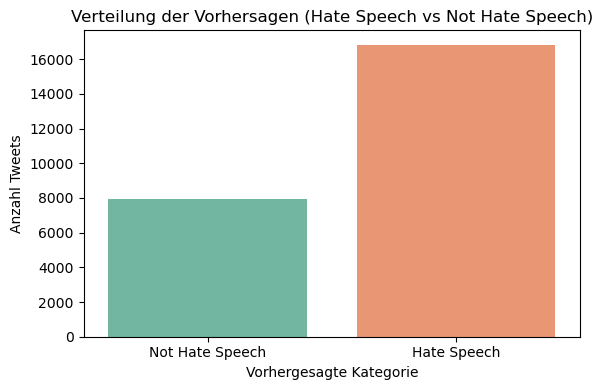

In [49]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="predicted_label", palette="Set2")
plt.title("Verteilung der Vorhersagen (Hate Speech vs Not Hate Speech)")
plt.xlabel("Vorhergesagte Kategorie")
plt.ylabel("Anzahl Tweets")
plt.tight_layout()
plt.show()

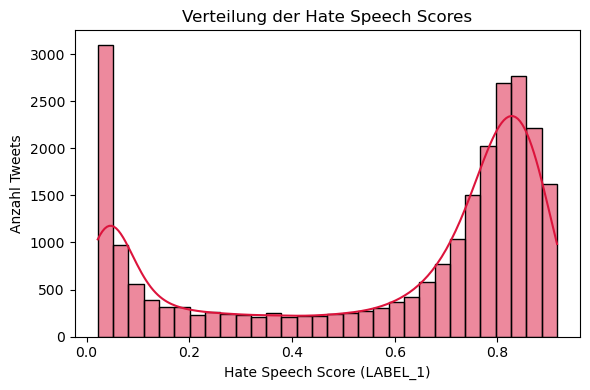

In [50]:
plt.figure(figsize=(6,4))
sns.histplot(df["label_1_score"], bins=30, kde=True, color="crimson")
plt.title("Verteilung der Hate Speech Scores")
plt.xlabel("Hate Speech Score (LABEL_1)")
plt.ylabel("Anzahl Tweets")
plt.tight_layout()
plt.show()

C:\Users\David\AppData\Local\Temp\ipykernel_22176\3436895414.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="predicted_label", y="label_1_score", palette="coolwarm")


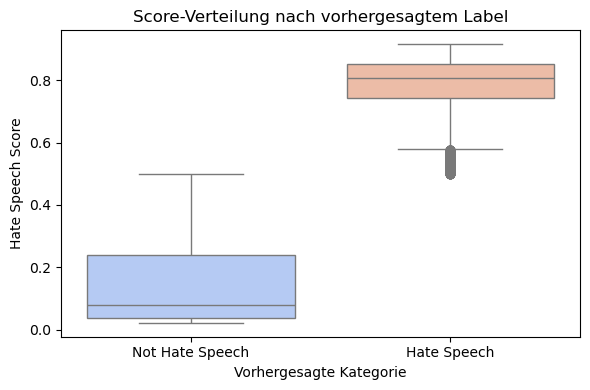

In [51]:
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x="predicted_label", y="label_1_score", palette="coolwarm")
plt.title("Score-Verteilung nach vorhergesagtem Label")
plt.xlabel("Vorhergesagte Kategorie")
plt.ylabel("Hate Speech Score")
plt.tight_layout()
plt.show()

In [52]:
top_hate = df.sort_values(by="label_1_score", ascending=False).head(10)
print(top_hate[["tweet", "label_1_score", "predicted_label"]])

                                                   tweet  label_1_score  \
6107                        @i2ose is it full of niggers       0.916127   
4822   @THERACISTDOCTOR One less little nigger that w...       0.916031   
5358            @_TriggaPlease_ @kanyewest he's a faggot       0.915817   
2458   @Ant_Dgk @Buckm00se @ChainskiBum would this fa...       0.914594   
21535     The blacks in #California are typical niggers.       0.914588   
5716                    @chanelisabeth that nigger music       0.914154   
5829      @delaney_guinan a faggot that needs to grow up       0.914092   
6229                            @jayswaggkillah Is a fag       0.913568   
6230                            @jayswaggkillah is a fag       0.913568   
4512                 @RedNationBlogga fuck those faggots       0.913514   

      predicted_label  
6107      Hate Speech  
4822      Hate Speech  
5358      Hate Speech  
2458      Hate Speech  
21535     Hate Speech  
5716      Hate Speech  
5829  

In [53]:
print("Classification Report:\n", classification_report(y_pred, y_true))

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.50      0.65      7959
           1       0.81      0.99      0.89     16824

    accuracy                           0.83     24783
   macro avg       0.88      0.74      0.77     24783
weighted avg       0.85      0.83      0.81     24783

